# Fire resistance classification

## Library loading, settings and dataset load

Hide warnings

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Main libraries load

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import time

Additional libraries

In [3]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from yellowbrick.classifier import ConfusionMatrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score 
from sklearn.metrics import f1_score, confusion_matrix, classification_report

Load Fire Resistance dataset

In [4]:
path = '/Users/manolo/Documents/Docencia/Tesis Doctorales/Elena Albeira Guirado Lucinio/Resistencia fuego/Datasets/'

In [5]:
df = pd.read_excel(path+'FR_FS_class.xlsx')

In [6]:
df.head()

,Thickness,Gypsum,Lomas ash,Vermiculite,Fiberglass,Ash,FGD gypsum Compostilla,Portland concrete,Silica sand,Coarse silica arid,Coarse demolition recycled arid,Bagasse ash,Zeolitized ash,Hidromag,FRR
0,2.0,100.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,FRR-30
1,2.0,30.0,60,9.5,0.5,0,0,0,0,0,0,0,0,0,FRR-15
2,1.5,99.5,0,0.0,0.0,0,0,0,0,0,0,0,0,0,FRR-15
3,1.5,30.0,60,9.5,0.5,0,0,0,0,0,0,0,0,0,FRR-15
4,4.0,30.0,60,9.5,0.5,0,0,0,0,0,0,0,0,0,FRR-90


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Thickness                        136 non-null    float64
 1   Gypsum                           136 non-null    float64
 2   Lomas ash                        136 non-null    int64  
 3   Vermiculite                      136 non-null    float64
 4   Fiberglass                       136 non-null    float64
 5   Ash                              136 non-null    int64  
 6   FGD gypsum Compostilla           136 non-null    int64  
 7   Portland concrete                136 non-null    int64  
 8   Silica sand                      136 non-null    int64  
 9   Coarse silica arid               136 non-null    int64  
 10  Coarse demolition recycled arid  136 non-null    int64  
 11  Bagasse ash                      136 non-null    int64  
 12  Zeolitized ash        

In [8]:
cat_feat = []
bin_feat = []
target = 'FRR'
drop = ['Rice husk ash', 'Silica fume', 'Fireproof cardboard']
exc = 't180'
exclude = cat_feat + bin_feat + [target] + drop + [exc]
num_feat = [col for col in df.columns if col not in exclude]

In [9]:
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns = target),
                                        df[target],
                                        test_size=0.25,
                                        random_state = 123
                                    )

print("Original dataframe size",df.shape)
print("Datafrane size without FS target for training", X_train.shape)
print("Target for training", y_train.shape)
print("Dataframe size without target for testing", X_test.shape)
print("Target for testing", y_test.shape)

Original dataframe size (136, 15)
Datafrane size without FS target for training (102, 14)
Target for training (102,)
Dataframe size without target for testing (34, 14)
Target for testing (34,)


Transformer for numerical variable standardization and categorical variable one-hot encoding

In [11]:
num_feat = X_train.columns

In [12]:
data_transformer = ColumnTransformer(
  transformers = [
    ('rescale numeric', preprocessing.StandardScaler(), num_feat),
    ('recode categorical', 
      preprocessing.OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), 
      cat_feat)
    ])

### Pipeline set-up

In [13]:
dtc = Pipeline(steps = [("prep", data_transformer), ('dtc', DecisionTreeClassifier())])
rfc = Pipeline(steps = [("prep", data_transformer), ('rfc', RandomForestClassifier())])
gbc = Pipeline(steps = [("prep", data_transformer), ('gbc', GradientBoostingClassifier())])
lc = Pipeline(steps=[("prep", data_transformer), ("lc", LogisticRegression())])
ridge = Pipeline(steps=[("prep", data_transformer), ("ridge", RidgeClassifier())])
knc = Pipeline(steps=[("prep", data_transformer), ("knc", KNeighborsClassifier())])
mlp = Pipeline(steps=[("prep", data_transformer), ("mlp", MLPClassifier())])
xgc = Pipeline(steps=[("prep", data_transformer), ("xgc", XGBClassifier())])

### RandomSearch

In [14]:
# Decision tree
grid_rs_dtc = {"dtc__max_depth": list(np.arange(2, 20, step = 2)) 
              }
# Random Forest
grid_rs_rfc = {"rfc__n_estimators": list(np.arange(10, 100, step = 10)), 
                     
                     "rfc__max_depth": list(np.arange(10, 50, step = 10)), 
                      
                     "rfc__max_features": ["sqrt", 3, 4] 
                     }
# Gradient Boosting
grid_rs_gbc = {"gbc__loss": ['log_loss'],
                          "gbc__learning_rate": list(np.arange(0.05, 1, step = 0.1)), 
                          
                          "gbc__n_estimators": list(np.arange(5, 30, step = 5)), 
                          
                          "gbc__max_depth": list(np.arange(15, 30, step = 5)), 
                          
                          "gbc__subsample": list(np.arange(0.5, 1, step = 0.1)), 
                          
                          "gbc__max_features": ["sqrt", 4, 8], 
                          }
# Ridge
grid_rs_ridge= {'ridge__alpha': list(np.arange(0.1, 5, step = 0.2))}

# Logistic regression
grid_rs_lc = {'lc__C': list(np.arange(0.1, 5, step=0.2))}

# KNeighbors
grid_rs_knc = {"knc__n_neighbors": list(np.arange(1, 15, step = 2)), 
                  "knc__weights": ["uniform","distance"]  
                  }

# Multi layer perceptron
grid_rs_mlp = {"mlp__hidden_layer_sizes": [(4,),             
                                        (4,4),           
                                        (30,),          
                                        (30,30)],
            
           "mlp__activation": ["relu"], 
            
           "mlp__solver": ["adam"], 
            
           "mlp__alpha": [0.0, 0.1], 
            
           "mlp__validation_fraction": [0.1], 
           "mlp__early_stopping": [True],    
           "mlp__max_iter": [3000],
            
           "mlp__learning_rate_init": list(np.arange(0.001, 0.1, step = 0.01)) 
           }

# XGBClassifier

grid_rs_xgc = {'xgc__max_depth': list(np.arange(1, 10, step = 1)),
            'xgc__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
            'xgc__n_estimators': list(np.arange(50, 200, step = 20))
            }

In [15]:
rs_dtc = RandomizedSearchCV(dtc, 
                    grid_rs_dtc,
                    n_iter = 100, 
                    cv=10, 
                    scoring="accuracy", 
                    verbose=1, 
                    n_jobs=-1)

rs_rfc = RandomizedSearchCV(rfc, 
                    grid_rs_rfc,
                    n_iter = 100, 
                    cv=10, 
                    scoring="accuracy", 
                    verbose=1, 
                    n_jobs=-1)

rs_gbc = RandomizedSearchCV(gbc, 
                    grid_rs_gbc,
                    n_iter = 100, 
                    cv=10, 
                    scoring="accuracy", 
                    verbose=1, 
                    n_jobs=-1)

rs_ridge = RandomizedSearchCV(ridge, 
                    grid_rs_ridge,
                    n_iter = 100, 
                    cv=10, 
                    scoring="accuracy", 
                    verbose=1, 
                    n_jobs=-1)

rs_lc = RandomizedSearchCV(lc, 
                    grid_rs_lc,
                    n_iter = 100, 
                    cv=10, 
                    scoring="accuracy", 
                    verbose=1, 
                    n_jobs=-1)

rs_knc = RandomizedSearchCV(knc, 
                    grid_rs_knc,
                    n_iter = 100, 
                    cv=10, 
                    scoring="accuracy", 
                    verbose=1, 
                    n_jobs=-1)

rs_mlp = RandomizedSearchCV(mlp,
                      grid_rs_mlp,
                      n_iter = 100,
                      cv=10,
                      scoring='accuracy',
                      verbose=1,
                      n_jobs=-1)

rs_xgc = RandomizedSearchCV(xgc, 
                    grid_rs_xgc,
                    n_iter = 100, 
                    cv=10, 
                    scoring="accuracy", 
                    verbose=1, 
                    n_jobs=-1)


In [16]:
all_rs_searchs = {"rs_dtc":rs_dtc,
                    "rs_rfc":rs_rfc,
                    "rs_gbc":rs_gbc,
                    "rs_ridge":rs_ridge,
                    "rs_lc":rs_lc,
                    "rs_knc":rs_knc,
                    "rs_mlp":rs_mlp,
                    "rs_xgc": rs_xgc
                    }

#### Model training

In [17]:
for name, grid_search in all_rs_searchs.items():
    start = time.time()
    print("Random Search of %s..." % name)
    grid_search.fit(X_train, y_train)
    stop = time.time()
    print(f"Training time: {stop - start} s")

Random Search of rs_dtc...
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Training time: 0.9328668117523193 s
Random Search of rs_rfc...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Training time: 1.7443571090698242 s
Random Search of rs_gbc...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Training time: 2.5457568168640137 s
Random Search of rs_ridge...
Fitting 10 folds for each of 25 candidates, totalling 250 fits
Training time: 0.09165215492248535 s
Random Search of rs_lc...
Fitting 10 folds for each of 25 candidates, totalling 250 fits
Training time: 0.12112188339233398 s
Random Search of rs_knc...
Fitting 10 folds for each of 14 candidates, totalling 140 fits
Training time: 0.05607485771179199 s
Random Search of rs_mlp...
Fitting 10 folds for each of 80 candidates, totalling 800 fits
Training time: 0.4673647880554199 s
Random Search of rs_xgc...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Training time: 1.472

#### Model performance

In [18]:
best_score_rs = [(nombre_modelo, grid_search.best_score_)
                                  for nombre_modelo, grid_search           
                                  in all_rs_searchs.items()]

best_score_rs_df = pd.DataFrame(best_score_rs, 
                                columns=["RandomSearchCV", 
                                         "Best score"]).sort_values(by="Best score", 
                                                                    ascending=False)

best_score_rs_df

,RandomSearchCV,Best score
2,rs_gbc,0.971818
0,rs_dtc,0.961818
5,rs_knc,0.961818
1,rs_rfc,0.951818
4,rs_lc,0.951818
7,rs_xgc,0.951818
6,rs_mlp,0.921818
3,rs_ridge,0.911818


##### KNC

In [19]:
best_randomsearch = all_rs_searchs["rs_knc"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'knc__weights': 'distance', 'knc__n_neighbors': 7}


In [20]:
# Obtener las predicciones del mejor modelo
y_pred = best_pipeline.predict(X_test)

# Calcular métricas de clasificación
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Imprimir las métricas
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

# Imprimir el classification report
print("\nClassification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred))

Accuracy: 0.91
Precision: 0.94
Recall: 0.91
F1-score: 0.92

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         7
           5       0.50      1.00      0.67         2

    accuracy                           0.91        34
   macro avg       0.90      0.94      0.90        34
weighted avg       0.94      0.91      0.92        34



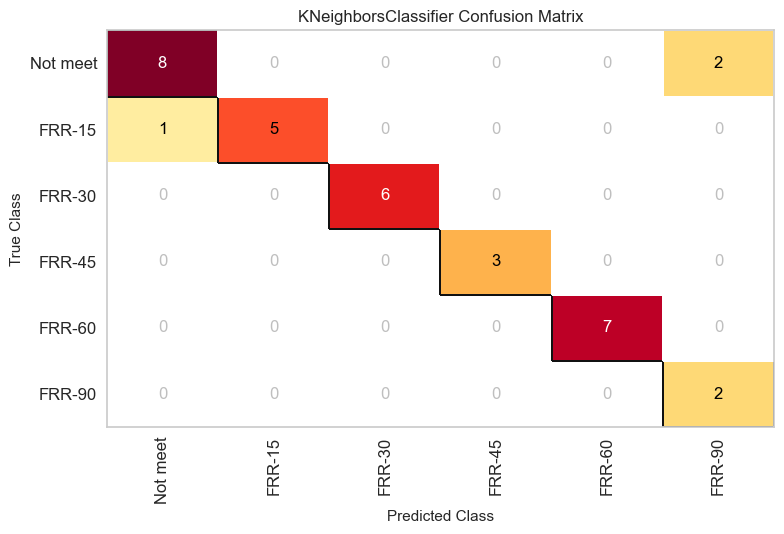

<Axes: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [21]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(best_pipeline, classes=['Not meet', 'FRR-15','FRR-30','FRR-45','FRR-60', 'FRR-90'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

##### GBC

In [22]:
best_randomsearch = all_rs_searchs["rs_gbc"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'gbc__subsample': 0.7999999999999999, 'gbc__n_estimators': 10, 'gbc__max_features': 8, 'gbc__max_depth': 25, 'gbc__loss': 'log_loss', 'gbc__learning_rate': 0.9500000000000002}


In [23]:
# Obtener las predicciones del mejor modelo
y_pred = best_pipeline.predict(X_test)

# Calcular métricas de clasificación
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Imprimir las métricas
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

# Imprimir el classification report
print("\nClassification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred))

Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1-score: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         2

    accuracy                           0.97        34
   macro avg       0.98      0.97      0.98        34
weighted avg       0.97      0.97      0.97        34



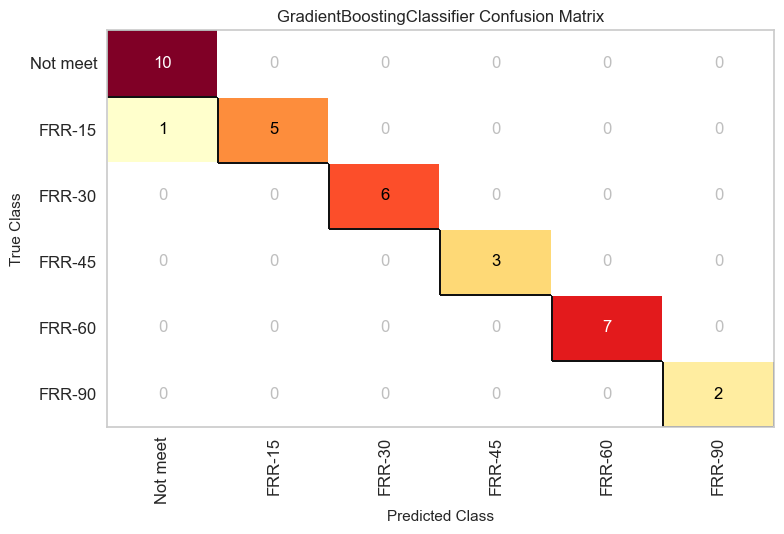

<Axes: title={'center': 'GradientBoostingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [24]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(best_pipeline, classes=['Not meet', 'FRR-15','FRR-30','FRR-45','FRR-60', 'FRR-90'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

##### RFC

In [25]:
best_randomsearch = all_rs_searchs["rs_rfc"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'rfc__n_estimators': 10, 'rfc__max_features': 3, 'rfc__max_depth': 10}


In [26]:
# Obtener las predicciones del mejor modelo
y_pred = best_pipeline.predict(X_test)

# Calcular métricas de clasificación
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Imprimir las métricas
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

# Imprimir el classification report
print("\nClassification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred))

Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1-score: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         2

    accuracy                           0.97        34
   macro avg       0.98      0.97      0.98        34
weighted avg       0.97      0.97      0.97        34



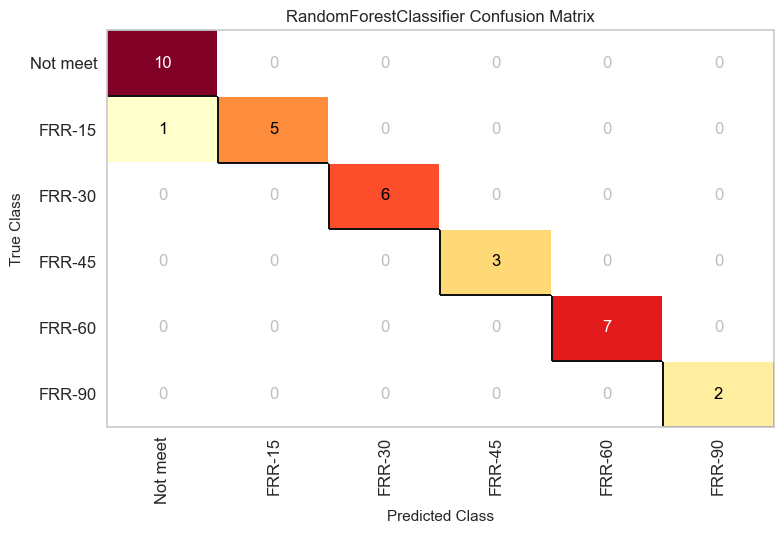

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [27]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(best_pipeline, classes=['Not meet', 'FRR-15','FRR-30','FRR-45','FRR-60', 'FRR-90'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

##### MLP

In [28]:
best_randomsearch = all_rs_searchs["rs_mlp"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'mlp__validation_fraction': 0.1, 'mlp__solver': 'adam', 'mlp__max_iter': 3000, 'mlp__learning_rate_init': 0.071, 'mlp__hidden_layer_sizes': (30,), 'mlp__early_stopping': True, 'mlp__alpha': 0.0, 'mlp__activation': 'relu'}


In [29]:
# Obtener las predicciones del mejor modelo
y_pred = best_pipeline.predict(X_test)

# Calcular métricas de clasificación
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Imprimir las métricas
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

# Imprimir el classification report
print("\nClassification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred))

Accuracy: 0.82
Precision: 0.89
Recall: 0.82
F1-score: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       1.00      0.83      0.91         6
           2       1.00      0.50      0.67         6
           3       0.50      1.00      0.67         3
           4       1.00      1.00      1.00         7
           5       0.50      1.00      0.67         2

    accuracy                           0.82        34
   macro avg       0.81      0.86      0.79        34
weighted avg       0.89      0.82      0.83        34



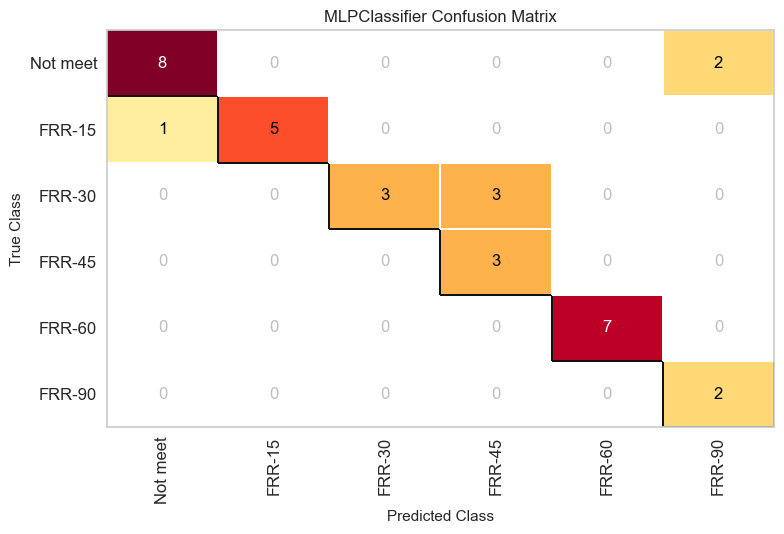

<Axes: title={'center': 'MLPClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [30]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(best_pipeline, classes=['Not meet', 'FRR-15','FRR-30','FRR-45','FRR-60', 'FRR-90'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

##### DTC

In [31]:
best_randomsearch = all_rs_searchs["rs_dtc"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'dtc__max_depth': 8}


In [32]:
# Obtener las predicciones del mejor modelo
y_pred = best_pipeline.predict(X_test)

# Calcular métricas de clasificación
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Imprimir las métricas
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

# Imprimir el classification report
print("\nClassification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred))

Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1-score: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         2

    accuracy                           0.97        34
   macro avg       0.98      0.97      0.98        34
weighted avg       0.97      0.97      0.97        34



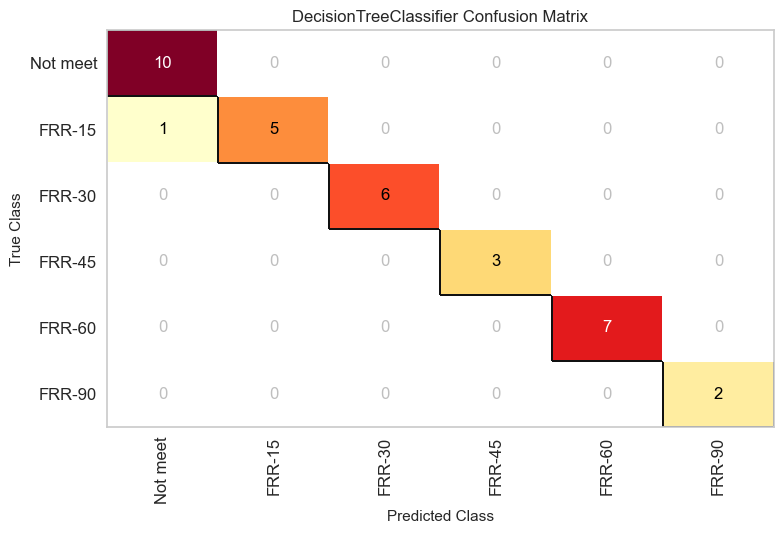

<Axes: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [33]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(best_pipeline, classes=['Not meet', 'FRR-15','FRR-30','FRR-45','FRR-60', 'FRR-90'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

##### XGC

In [34]:
best_randomsearch = all_rs_searchs["rs_xgc"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'xgc__n_estimators': 110, 'xgc__max_depth': 4, 'xgc__learning_rate': 0.3}


In [35]:
# Obtener las predicciones del mejor modelo
y_pred = best_pipeline.predict(X_test)

# Calcular métricas de clasificación
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Imprimir las métricas
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

# Imprimir el classification report
print("\nClassification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred))

Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1-score: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.83      0.91         6
           2       0.86      1.00      0.92         6
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         2

    accuracy                           0.97        34
   macro avg       0.98      0.97      0.97        34
weighted avg       0.97      0.97      0.97        34



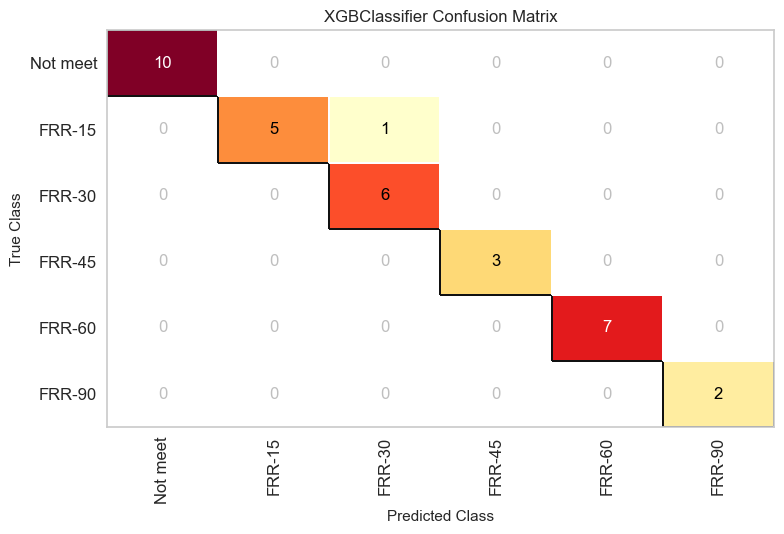

<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [36]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(best_pipeline, classes=['Not meet', 'FRR-15','FRR-30','FRR-45','FRR-60', 'FRR-90'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

##### RIDGE

In [37]:
best_randomsearch = all_rs_searchs["rs_ridge"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'ridge__alpha': 0.1}


In [38]:
# Obtener las predicciones del mejor modelo
y_pred = best_pipeline.predict(X_test)

# Calcular métricas de clasificación
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Imprimir las métricas
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

# Imprimir el classification report
print("\nClassification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred))

Accuracy: 0.82
Precision: 0.89
Recall: 0.82
F1-score: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       1.00      0.83      0.91         6
           2       1.00      0.50      0.67         6
           3       0.50      1.00      0.67         3
           4       1.00      1.00      1.00         7
           5       0.50      1.00      0.67         2

    accuracy                           0.82        34
   macro avg       0.81      0.86      0.79        34
weighted avg       0.89      0.82      0.83        34



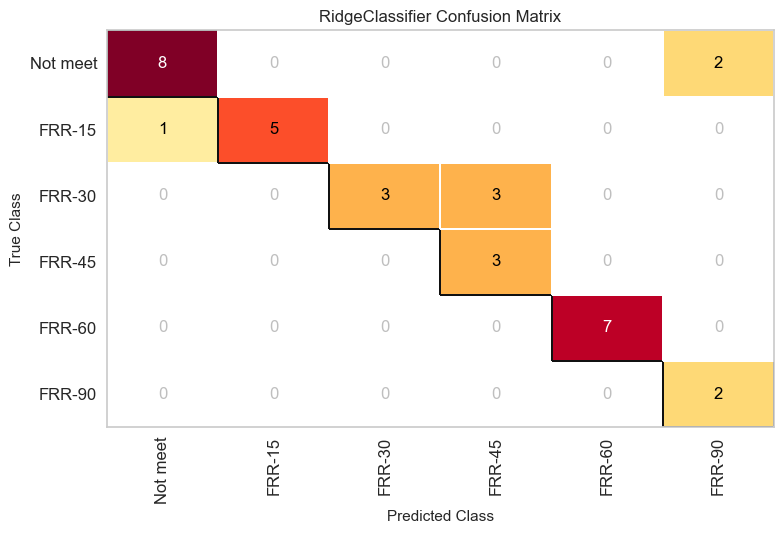

<Axes: title={'center': 'RidgeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [39]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(best_pipeline, classes=['Not meet', 'FRR-15','FRR-30','FRR-45','FRR-60', 'FRR-90'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

##### LOGISTIC

In [40]:
best_randomsearch = all_rs_searchs["rs_lc"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'lc__C': 3.500000000000001}


In [41]:
# Obtener las predicciones del mejor modelo
y_pred = best_pipeline.predict(X_test)

# Calcular métricas de clasificación
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Imprimir las métricas
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

# Imprimir el classification report
print("\nClassification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred))

Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1-score: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         2

    accuracy                           0.97        34
   macro avg       0.98      0.97      0.98        34
weighted avg       0.97      0.97      0.97        34



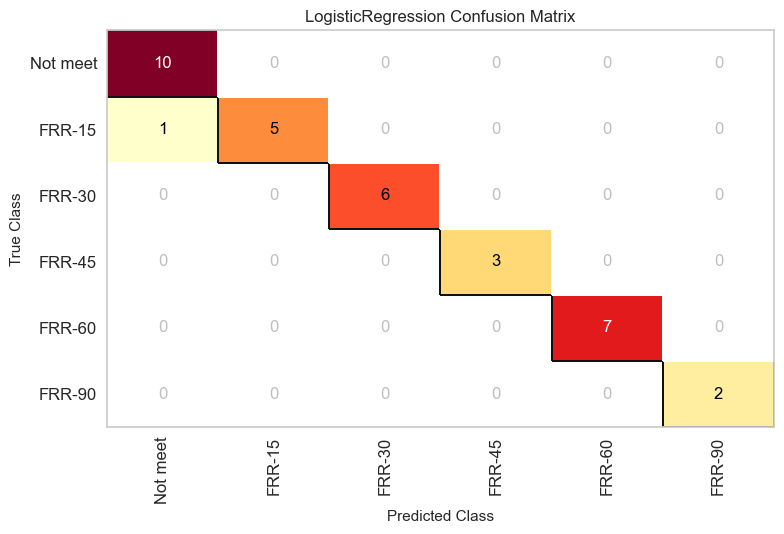

<Axes: title={'center': 'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [42]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(best_pipeline, classes=['Not meet', 'FRR-15','FRR-30','FRR-45','FRR-60', 'FRR-90'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()